# Simulação do nível de dois tanques com uma PIRNN


## 1. Importa bibliotecas e configurações básicas


In [1]:
import os

import numpy as np
import torch

from lib.export_params import models_folder

# Ativando otimizações
from lib.utils import enable_optimizations

enable_optimizations()

# Setando sementes
np.random.seed(42)
torch.manual_seed(42)

# Configurando tipo das variáveis
dtype = torch.float32
torch.set_default_dtype(dtype)

# Definindo nome do modelo
model_name = "pirnn"
model_path = f"{models_folder}{model_name}.pt"


## 2. Gera dados de treinamento


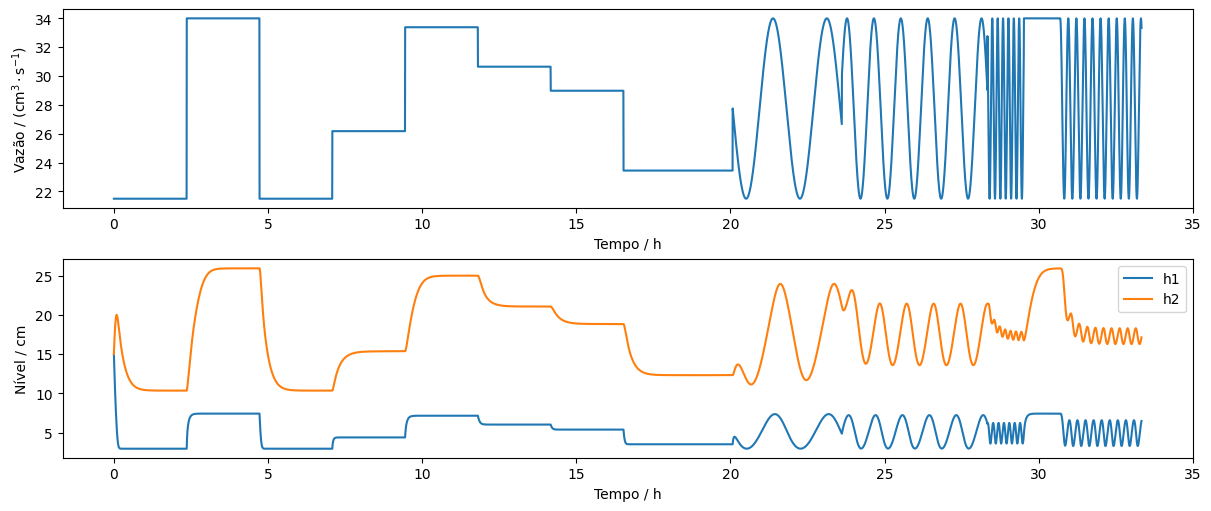

In [2]:
from typing import Any

from lib.common_plots import plot_flow_and_level, plot_tanks
from lib.physical_systems import Spherical_tanks

tanks = Spherical_tanks()
q_min = 21.5
q_max = 34.0

random_q_array = np.random.uniform(q_min, q_max, size=12)


def q_train(t, op: Any = np):
    spacing = 8500
    output = op.ones_like(t) * q_min
    output = op.where(t >= 1 * spacing, q_max, output)
    output = op.where(t >= 2 * spacing, q_min, output)
    output = op.where(t >= 3 * spacing, random_q_array[0], output)
    output = op.where(t >= 4 * spacing, random_q_array[1], output)
    output = op.where(t >= 5 * spacing, random_q_array[2], output)
    output = op.where(t >= 6 * spacing, random_q_array[3], output)
    output = op.where(t >= 7 * spacing, random_q_array[4], output)
    output = op.where(t >= 8 * spacing, random_q_array[5], output)
    output = op.where(
        t >= 8.5 * spacing,
        op.sin(t / 1000) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 10 * spacing,
        op.sin(t / 500) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(
        t >= 12 * spacing,
        op.sin(t / 100) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )
    output = op.where(t >= 12.5 * spacing, q_max, output)
    output = op.where(
        t >= 13 * spacing,
        op.sin(t / 150) * ((q_max - q_min) / 2) + (q_max + q_min) / 2,
        output,
    )

    return output


tanks.set_simulation_parameters(q_train, (0, 120000), 120000 // 10, y0=[15, 15])
h_cas = tanks.simulate_casadi("rk")

h1_cas, h2_cas = torch.tensor(h_cas, dtype=dtype)
q_train_tensor = torch.tensor(q_train(tanks.t_numpy), dtype=dtype)

plot_flow_and_level(tanks.t_numpy, q_train_tensor, h_cas, ["h1", "h2"])


## 3. Prepara os dados para serem compatíveis com a entrada de uma RNN


In [3]:
from lib.utils import prepare_sequences

# Quantidade de pontos históricos fornecidos para a rede
history_size = 2

X_true, Y_true = prepare_sequences(
    (h1_cas, h2_cas, q_train_tensor), (h1_cas, h2_cas), history_size
)

# Resultado
print("X_true shape:", X_true.shape)  # Deve ser (batch_size, input_size, seq_len)
# print("X_true:", X_true[0:3])
print("Y_true shape:", Y_true.shape)  # Deve ser (batch_size, output_size)
# print("Y_true:", Y_true[0:3])


X_true shape: torch.Size([11998, 2, 3])
Y_true shape: torch.Size([11998, 2])


## 4. Cria a rede neural


In [4]:
from lib.models import RNN, DataInfo

normalization_data: DataInfo = {
    "in_min": torch.tensor([tanks.h_min, tanks.h_min, q_min], dtype=torch.float32),
    "in_max": torch.tensor([tanks.h_max, tanks.h_max, q_max], dtype=torch.float32),
    "out_min": torch.tensor([tanks.h_min, tanks.h_min], dtype=torch.float32),
    "out_max": torch.tensor([tanks.h_max, tanks.h_max], dtype=torch.float32),
}

model = RNN(3, 32, 2, normalization_data)

with torch.inference_mode():
    print(model(X_true)[:3])
    print(Y_true[:3])


tensor([[14.9339, 12.9970],
        [14.9285, 12.9931],
        [14.9231, 12.9893]])
tensor([[14.2443, 15.6222],
        [13.8788, 15.9153],
        [13.5210, 16.1969]])


## 6. Treina a rede neural


In [5]:
from torch import optim

from lib.common_plots import plot_loss
from lib.utils import mean_square, notify_training_end


def loss_fn(model, _):
    output = model(X_true)

    # Data loss
    h1_true = Y_true[:, 0]
    h2_true = Y_true[:, 1]
    h1_prev = output[:, 0]
    h2_prev = output[:, 1]

    loss_data_h1 = mean_square(h1_true - h1_prev)
    loss_data_h2 = mean_square(h2_true - h2_prev)

    # Loss EDO
    h1_past_true = X_true[:, -1, 0]
    h1_past2_true = X_true[:, -2, 0]

    h2_past_true = X_true[:, -1, 1]
    h2_past2_true = X_true[:, -2, 1]
    q = X_true[:, -1, 2]

    dh1dt_edo, dh2dt_edo = tanks.edo_torch(None, torch.stack([h1_prev, h2_prev]), q)
    # Derivadas regressivas com 3 pontos
    dh1dt_euler = (3 * h1_prev - 4 * h1_past_true + h1_past2_true) / (2 * tanks.dt)
    dh2dt_euler = (3 * h2_prev - 4 * h2_past_true + h2_past2_true) / (2 * tanks.dt)

    loss_edo_h1 = mean_square(dh1dt_edo - dh1dt_euler)
    loss_edo_h2 = mean_square(dh2dt_edo - dh2dt_euler)

    loss_total = loss_data_h1 + loss_data_h2 + loss_edo_h1 + loss_edo_h2
    return loss_total, [
        loss_data_h1.detach(),
        loss_data_h2.detach(),
        loss_edo_h1.detach(),
        loss_edo_h2.detach(),
    ]


if not os.path.exists(model_path):
    print("Não foi possível recuperar os parâmetros")
    print("Treinando o modelo...")
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    history = model.fit(optimizer, loss_fn, 500)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history.extend(model.fit(optimizer, loss_fn, 5000))

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    history.extend(model.fit(optimizer, loss_fn, 5000))

    notify_training_end()

    plot_loss(history, ["Loss data 1", "Loss data 2", "Loss EDO 1", "Loss EDO 2"])
    model.eval()
    torch.save(model.state_dict(), model_path)
else:
    print("Recuperando os parâmetros do modelo...")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    print("Parâmetros recuperados. Não será necessário reexecutar o treinamento.")


Recuperando os parâmetros do modelo...
Parâmetros recuperados. Não será necessário reexecutar o treinamento.


## 5. Testa a PIRNN com a vazão de treinamento


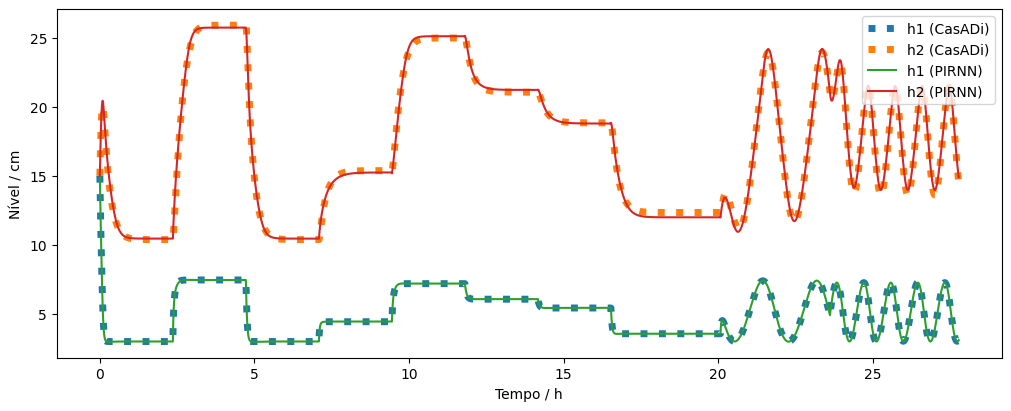

In [6]:
@torch.inference_mode()
def predict(h1, h2, q):
    # Aloca os tensores que vão ser utilizados
    predicted_h1 = torch.zeros_like(h1)
    predicted_h2 = torch.zeros_like(h2)
    input = torch.zeros((1, history_size, 3))

    # Normalizar e preencher com os valores iniciais
    predicted_h1[:history_size] = model.normalize(
        h1[:history_size], model.in_min[0], model.in_max[0]
    )
    predicted_h2[:history_size] = model.normalize(
        h2[:history_size], model.in_min[1], model.in_max[1]
    )
    q = model.normalize(q, model.in_min[2], model.in_max[2])

    for i in range(history_size, len(h1)):
        # (batch_size, seq_len, input_size)
        input[0, :, 0] = predicted_h1[i - history_size : i]
        input[0, :, 1] = predicted_h2[i - history_size : i]
        input[0, :, 2] = q[i - history_size : i]

        Y_prev = model(input, True)

        predicted_h1[i] = Y_prev[0][0]
        predicted_h2[i] = Y_prev[0][1]

    # Denormalize
    predicted_h1 = model.denormalize(
        predicted_h1,
        model.out_min[0],
        model.out_max[0],
    )
    predicted_h2 = model.denormalize(
        predicted_h2,
        model.out_min[1],
        model.out_max[1],
    )
    return predicted_h1, predicted_h2


h1_pirnn, h2_pirnn = predict(h1_cas, h2_cas, q_train_tensor)

show_only = 10000

plot_tanks(
    tanks.t_numpy[:show_only],
    (
        h1_cas[:show_only],
        h2_cas[:show_only],
        h1_pirnn[:show_only],
        h2_pirnn[:show_only],
    ),
    ["h1 (CasADi)", "h2 (CasADi)", "h1 (PIRNN)", "h2 (PIRNN)"],
    2,
    "pirnn-result",
    legend_loc="upper right",
)


# Exportando modelo


In [7]:
import onnxruntime as ort

from lib.export_params import export_params

export_params(model, model_name)

dummy_input = torch.randn(1, history_size, 3)

onnx_file_path = f"{models_folder}{model_name}.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],
    output_names=["output"],
)

ort_session = ort.InferenceSession(onnx_file_path)


def predict_onnx(h1, h2, q):
    # Aloca os tensores que vão ser utilizados
    predicted_h1 = np.zeros_like(h1, dtype=np.float32)
    predicted_h2 = np.zeros_like(h2, dtype=np.float32)
    input = np.zeros((1, history_size, 3), dtype=np.float32)

    # Normalizar e preencher com os valores iniciais
    predicted_h1[:history_size] = model.normalize(
        h1[:history_size], model.in_min[0], model.in_max[0]
    )
    predicted_h2[:history_size] = model.normalize(
        h2[:history_size], model.in_min[1], model.in_max[1]
    )
    q = model.normalize(q, model.in_min[2], model.in_max[2])

    for i in range(history_size, len(h1)):
        # (batch_size, seq_len, input_size)
        input[0, :, 0] = predicted_h1[i - history_size : i]
        input[0, :, 1] = predicted_h2[i - history_size : i]
        input[0, :, 2] = q[i - history_size : i]

        Y_prev = ort_session.run(None, {"input": input})

        predicted_h1[i] = Y_prev[0][0][0]
        predicted_h2[i] = Y_prev[0][0][1]

    # Denormalize
    predicted_h1 = model.denormalize(
        torch.from_numpy(predicted_h1),
        model.out_min[0],
        model.out_max[0],
    )
    predicted_h2 = model.denormalize(
        torch.from_numpy(predicted_h2),
        model.out_min[1],
        model.out_max[1],
    )
    return predicted_h1, predicted_h2


/home/silas/workspace/PSE-NE-2024/PyTorch/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


# Benchmarking com outros métodos


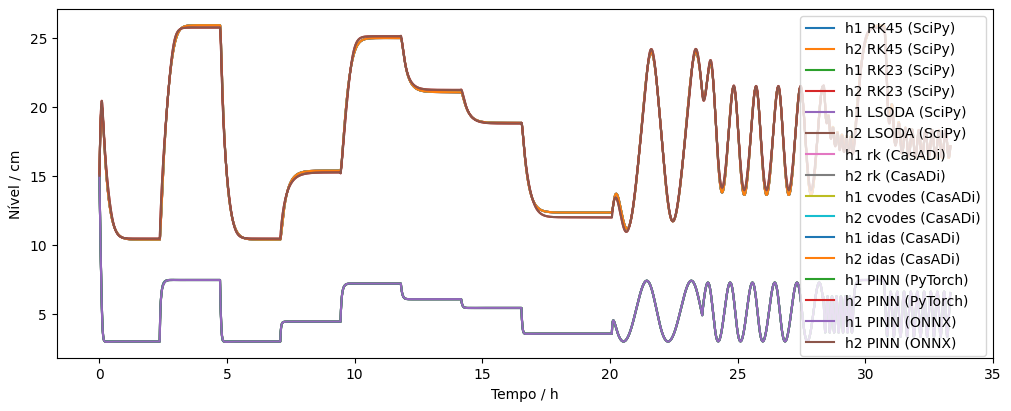

Recuperando medições


In [8]:
import hickle as hkl

from lib.common_plots import plot_density
from lib.utils import timer


def test_pytorch(args):
    return predict(*args)


def test_onnx(args):
    return predict_onnx(*args)


methods = [
    ("RK45 (SciPy)", tanks.simulate_scipy, "RK45", []),
    ("RK23 (SciPy)", tanks.simulate_scipy, "RK23", []),
    ("LSODA (SciPy)", tanks.simulate_scipy, "LSODA", []),
    ("rk (CasADi)", tanks.simulate_casadi, "rk", []),
    ("cvodes (CasADi)", tanks.simulate_casadi, "cvodes", []),
    ("idas (CasADi)", tanks.simulate_casadi, "idas", []),
    ("PINN (PyTorch)", test_pytorch, (h1_cas, h2_cas, q_train_tensor), []),
    ("PINN (ONNX)", test_onnx, (h1_cas, h2_cas, q_train_tensor), []),
]

results = []
for method, func, arg, times in methods:
    (h1, h2), _ = timer(func, arg)
    results.extend([h1, h2])

# Comparação gráfica
labels = []
for method in methods:
    labels.append(f"h1 {method[0]}")  # Para h1
    labels.append(f"h2 {method[0]}")  # Para h2

plot_tanks(tanks.t_numpy, results, labels)

# Medir vários tempos de execução
times_file = f"../benchmarks/{model_name}.hkl"
times = []

if os.path.isfile(times_file):
    print("Recuperando medições")
    times = hkl.load(times_file)
else:
    print("Não foi possível recuperar medições. Medindo novamente...")
    for _ in range(100):
        for method, func, arg, times in methods:
            _, elapsed_time = timer(func, arg)
            times.append(elapsed_time)
    times = [method[3] for method in methods]
    hkl.dump(times, times_file)

# Cria imagem do benchmark
plot_density(times, [method[0] for method in methods], f"{model_name}-benchmark")


In [9]:
from lib.common_plots import plot_boxplot

data = {
    "Métodos": ["RK45 (SciPy)"] * len(times[0])
    + ["RK23 (SciPy)"] * len(times[1])
    + ["LSODA (SciPy)"] * len(times[2])
    + ["rk (CasADi)"] * len(times[3])
    + ["cvodes (CasADi)"] * len(times[4])
    + ["idas (CasADi)"] * len(times[5])
    + ["PIRNN"] * len(times[7]),
    "Tempos": np.log(
        np.concatenate(
            [times[0], times[1], times[2], times[3], times[4], times[5], times[7]]
        )
    ),
}

plot_boxplot(data, f"{model_name}-boxplot")
